Heart Failures - ML in healthcare
===

In [527]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [528]:
# from scipy.stats import norm
# from sklearn.preprocessing import StandardScaler
# from scipy import stats
# import warnings
# warnings.filterwarnings('ignore')
%matplotlib inline
import torch
import torch.nn.functional as F
# import param

In [529]:
# import sklearn as sk
# import scipy
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [553]:
import param
import panel as pn
pn.extension()
import datetime as dt
import importlib
from importlib import reload
from tqdm import tqdm

In [531]:
import graph as gr
import params as par
import py_lib as lib
reload(gr)
reload(par)
reload(lib)
import graph as gr
import params as par
import py_lib as lib

In [532]:
format_dict = par.create_format_dict()
format_dict

{'Age': '{:.0f}',
 'RestingBP': '{:.0f}',
 'Cholesterol': '{:.0f}',
 'MaxHR': '{:.0f}',
 'FastingBS': '{:.1f}',
 'HeartDisease': '{:.1f}',
 'Oldpeak': '{:.2f}'}

# Import Data

In [189]:
df_heart = pd.read_csv('heart.csv')
# df_heart_test = pd.read_csv('ml4h_data/project1/heart_failure/test_split.csv')
# df_heart_train = pd.read_csv('ml4h_data/project1/heart_failure/train_val_split.csv')
df_heart_test = pd.read_csv('test_split.csv')
df_heart_train = pd.read_csv('train_val_split.csv')

In [190]:
df_heart.head(2)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1


In [191]:
df_heart.describe().style.format(format_dict)

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918,918,918,918.0,918,918.00,918.0
mean,54,132,199,0.2,137,0.89,0.6
std,9,19,109,0.4,25,1.07,0.5
min,28,0,0,0.0,60,-2.60,0.0
25%,47,120,173,0.0,120,0.00,0.0
50%,54,130,223,0.0,138,0.60,1.0
75%,60,140,267,0.0,156,1.50,1.0
max,77,200,603,1.0,202,6.20,1.0


## Variables by data types

In [192]:
df_heart.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

In [193]:
dft = df_heart.dtypes
cols_num = list(dft[dft == 'int64'].index)
cols_num.append('Oldpeak')
cols_num_with_binary = [x for x in cols_num]
cols_num.remove('FastingBS')
cols_num.remove('HeartDisease')
cols_num

['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

In [194]:
cols_obj = list(dft[dft == 'object'].index)
cols_obj_pure = [x for x in cols_obj]
cols_obj.append('FastingBS')
cols_obj.append('HeartDisease')
cols_obj

['Sex',
 'ChestPainType',
 'RestingECG',
 'ExerciseAngina',
 'ST_Slope',
 'FastingBS',
 'HeartDisease']

In [195]:
col_names = list(df_heart.columns)
col_names

['Age',
 'Sex',
 'ChestPainType',
 'RestingBP',
 'Cholesterol',
 'FastingBS',
 'RestingECG',
 'MaxHR',
 'ExerciseAngina',
 'Oldpeak',
 'ST_Slope',
 'HeartDisease']

## Numerical variables distributions

In [196]:
cols_num

['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

In [197]:
df_heart['FastingBS'].value_counts().values

array([704, 214])

In [198]:
import graph as gr
reload(gr)
import graph as gr

/home/pinolej/eth/healthcare/heart/graph.py:65: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


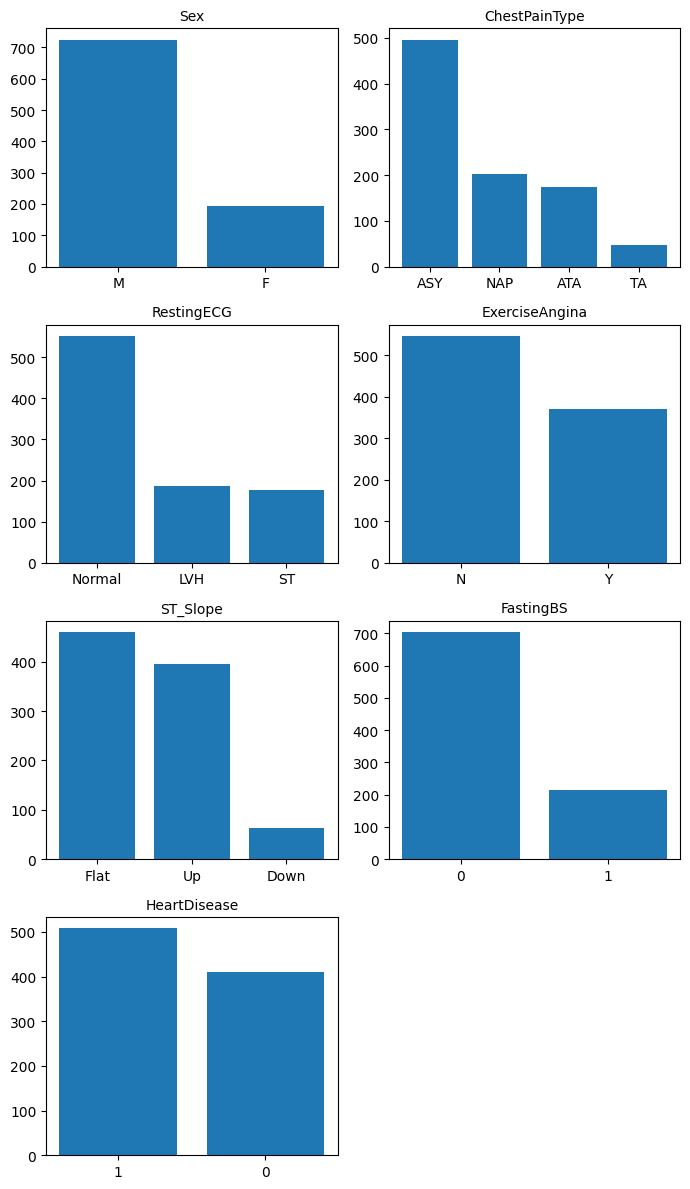

In [199]:
gr.dist_mult_plots(
    df_heart,
    cols=cols_obj,
    figsize=(7, 12),
    ncols=2,
    bar_plot=True,
    fontsize={
        'ax_title': 10,
    },
    custom_bins={'FastingBS': 60},
)

/home/pinolej/eth/healthcare/heart/graph.py:65: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


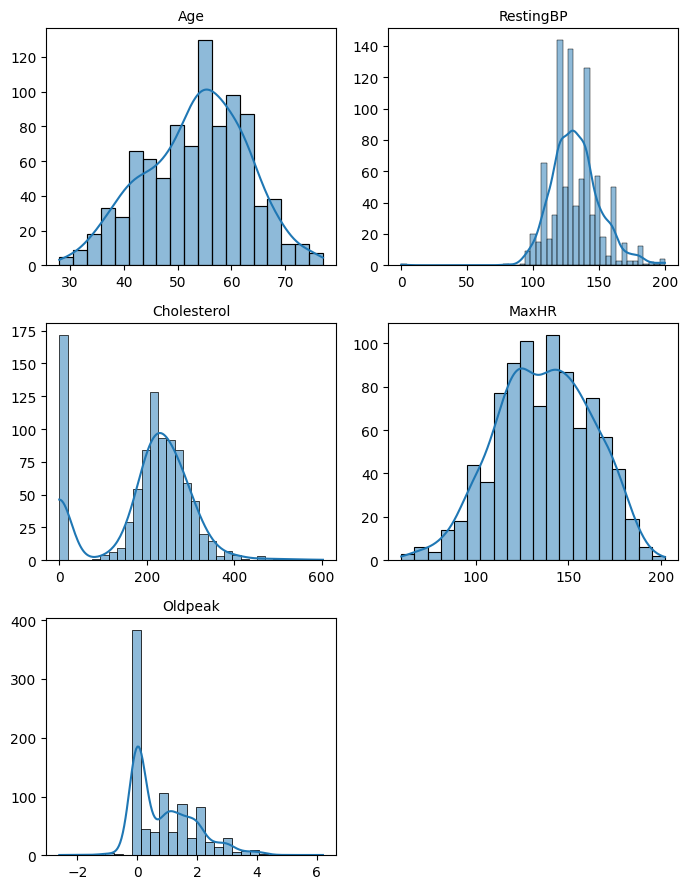

In [200]:
gr.dist_mult_plots(
    df_heart,
    cols=cols_num,
    figsize=(7, 9),
    ncols=2,
    fontsize={
        'ax_title': 10,
    },
    custom_bins={'FastingBS': 60},
)

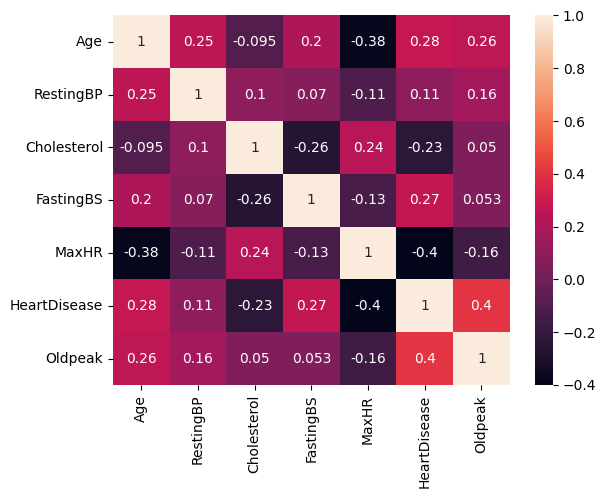

In [201]:
sns.heatmap(df_heart[cols_num_with_binary].corr(), annot=True)
plt.show()

## Missing values and Outliers

In [208]:
df_heart.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

# Lasso Logistic Regression

In [554]:
class LogisticParams(param.Parameterized):
    lr_multiple              = param.Number(5, bounds=(1,10), doc="Learning Rate Multiple of 10^x")
    lr_power                 = param.Integer(default=3, bounds=(1,9),doc="Learning Rate exponent of 10^x")
    epochs                   = param.Integer(default=5 ,bounds=(1,2000))
    num_var                  = param.ObjectSelector(default="Age",objects=cols_num)
    stand_features           = param.Boolean(True, doc="Whether we want to standardize numerical features")
    use_lasso                = param.Boolean(True)
    iter_array               = param.Integer(default=5, bounds=(1,20),doc="How often to save loss and training data, in epochs")
    iter_printing            = param.Integer(default=5, bounds=(1,100),doc="How many epochs between printing")
    add_one_hot_encoded      = param.Boolean(True, doc="Whether to add one hot encoded columns from categorical variables")
    test_size                = param.Number(0.2, bounds=(0.1,0.9), doc="Test size for train_test_split")
# pn.Param(CustomExample.param, widgets={
#     'select_string': {'type': pn.widgets.RadioButtonGroup, 'button_type': 'primary'},
#     'select_number': pn.widgets.DiscretePlayer}
# )
base = LogisticParams()

## Features Preprocessing

In [555]:
num_features = ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']
label_col = 'HeartDisease'
categorical_features = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
for col in df_heart.columns:
    if col not in num_features + [label_col] + categorical_features:
        print(f'Column {col} is not in the list of features')

In [556]:
pn.Column(pn.Row(base.param.add_one_hot_encoded, base.param.stand_features, base.param.test_size))

BokehModel(combine_events=True, render_bundle={'docs_json': {'0fc76884-3fce-4210-bcf7-e1a24f8f130b': {'version…

In [557]:
import py_lib as lib
reload(lib)
import py_lib as lib

In [558]:
train_test_data, final_categorical_features = lib.pre_process_features(
        df_heart_train,
        num_features=num_features,
        categorical_features=categorical_features,
        label_col=label_col,
        add_one_hot_encoded=base.add_one_hot_encoded,
        stand_features=base.stand_features,
        test_size=base.test_size,
        random_state=42,
)
X_train, X_test = train_test_data.tensors['X_train'], train_test_data.tensors['X_test']
y_train, y_test = train_test_data.tensors['y_train'], train_test_data.tensors['y_test']
X_train_df = train_test_data.dataframes['X_train']

In [559]:

X_train_df.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
135,0.437500,0.700,0.436673,0.0,0.592593,0.853659,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
473,0.729167,0.705,0.461248,1.0,0.414815,0.426829,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
254,0.937500,0.725,0.000000,1.0,0.466667,0.402439,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
525,0.270833,0.650,0.340265,0.0,0.666667,0.243902,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
164,0.354167,0.600,0.434783,0.0,0.666667,0.243902,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


## Model Building

In [560]:
class LogisticRegression(torch.nn.Module):
     
     def __init__(self, input_dim, output_dim):
         super(LogisticRegression, self).__init__()
         self.linear = torch.nn.Linear(input_dim, output_dim)
         

     def forward(self, x):
         outputs = torch.sigmoid(self.linear(x))
         return outputs
     

     def compute_loss(self, y_pred, y_true):
         return F.binary_cross_entropy(y_pred, y_true)


     def compute_l1_loss(self, w):
         return torch.abs(w).sum()

    

## Training

In [561]:
pn.Column(pn.Row(base.param.lr_power, base.param.lr_multiple, base.param.use_lasso))

BokehModel(combine_events=True, render_bundle={'docs_json': {'d41592a1-737a-42ab-8897-cba4dea6cc4a': {'version…

In [562]:
lr = base.lr_multiple * 10**(-base.lr_power)
print('learning rate is {} multiplied by 10 power {}, which yields {:.8f}'.format(
    base.lr_multiple,
    -base.lr_power,
    lr,
    ))

learning rate is 5 multiplied by 10 power -3, which yields 0.00500000


In [563]:
pn.Column(
    pn.Row(base.param.epochs, base.param.iter_array, base.param.iter_printing),
    )

BokehModel(combine_events=True, render_bundle={'docs_json': {'985aaae5-8301-4375-8e1b-3b49c673588d': {'version…

In [564]:
input_dim = len(num_features + final_categorical_features)
output_dim = 1 # Single binary output
model = LogisticRegression(input_dim,output_dim)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
iter_printing_effective = int(base.epochs/base.iter_printing)
print('iter_printing_effective is {}'.format(iter_printing_effective))
# torch.manual_seed(0) # keep things reproducible

iter_printing_effective is 1


In [565]:
losses = []
losses_test = []
Iterations = []
iter = 0
for epoch in tqdm(range(int(base.epochs)),desc='Training Epochs'):
    x = X_train
    labels = y_train
    optimizer.zero_grad() # Setting our stored gradients equal to zero
    outputs = model(X_train)  # Perform forward pass
    loss = criterion(torch.squeeze(outputs), labels) # Compute loss
    
    loss.backward() # Computes the gradient of the given tensor w.r.t. the weights/bias

    # Compute L1 loss component
    if base.param.use_lasso:
        l1_weight = 1.0
        l1_parameters = []
        for parameter in model.parameters():
            l1_parameters.append(parameter.view(-1))
        l1 = l1_weight * model.compute_l1_loss(torch.cat(l1_parameters))
        
        # Add L1 loss component
        loss += l1
    
    optimizer.step() # Updates weights and biases with the optimizer (SGD)
    
    iter+=1
    if iter%base.iter_array==0:
        with torch.no_grad():
            # Calculating the loss and accuracy for the test dataset
            correct_test = 0
            total_test = 0
            outputs_test = torch.squeeze(model(X_test))
            loss_test = criterion(outputs_test, y_test)
            
            predicted_test = outputs_test.round().detach().numpy()
            total_test += y_test.size(0)
            correct_test += np.sum(predicted_test == y_test.detach().numpy())
            accuracy_test = 100 * correct_test/total_test
            losses_test.append(loss_test.item())
            
            # Calculating the loss and accuracy for the train dataset
            total = 0
            correct = 0
            total += y_train.size(0)
            correct += np.sum(torch.squeeze(outputs).round().detach().numpy() == y_train.detach().numpy())
            accuracy = 100 * correct/total
            losses.append(loss.item())
            Iterations.append(iter)

            if iter%iter_printing_effective==0:
                print(f"Iteration: {iter}. \nTest - Loss: {loss_test.item()}. Accuracy: {accuracy_test}")
                print(f"Train -  Loss: {loss.item()}. Accuracy: {accuracy}\n")

Training Epochs: 100%|██████████| 5/5 [00:00<00:00, 371.35it/s]

Iteration: 5. 
Test - Loss: 0.6974419355392456. Accuracy: 53.06122448979592
Train -  Loss: 2.4758548736572266. Accuracy: 49.23339011925042



Text(0, 0.5, 'BCE Loss')

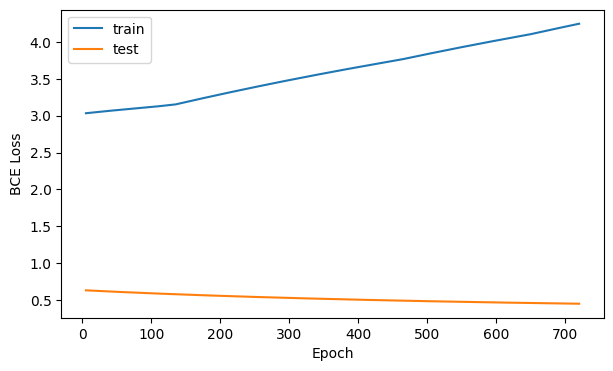

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (7,4))
ax.plot(Iterations,losses, label='train')
ax.plot(Iterations,losses_test, label='test')
ax.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('BCE Loss')
# fig.show()

In [549]:
for name, model_param in model.named_parameters():
    print(name)
    if name == 'linear.weight':
        weights = model_param.data
print(weights)
coefficients = weights.detach().numpy()
coefficients.flatten()

linear.weight
linear.bias
tensor([[ 0.1888,  0.1871,  0.0685,  0.0143, -0.0784, -0.0872, -0.2945,  0.0463,
          0.3687, -0.2933, -0.1263,  0.0039,  0.1014, -0.1732, -0.1013, -0.3751,
          0.4070, -0.0346,  0.5162, -0.2872]])


array([ 0.18882258,  0.1870531 ,  0.06850363,  0.01427855, -0.07844042,
       -0.08719739, -0.29445365,  0.04634728,  0.3687389 , -0.2932945 ,
       -0.12632836,  0.00386082,  0.10139325, -0.17317821, -0.10132835,
       -0.37509006,  0.40704235, -0.03460733,  0.5161933 , -0.2872146 ],
      dtype=float32)

<Axes: ylabel='Feature'>

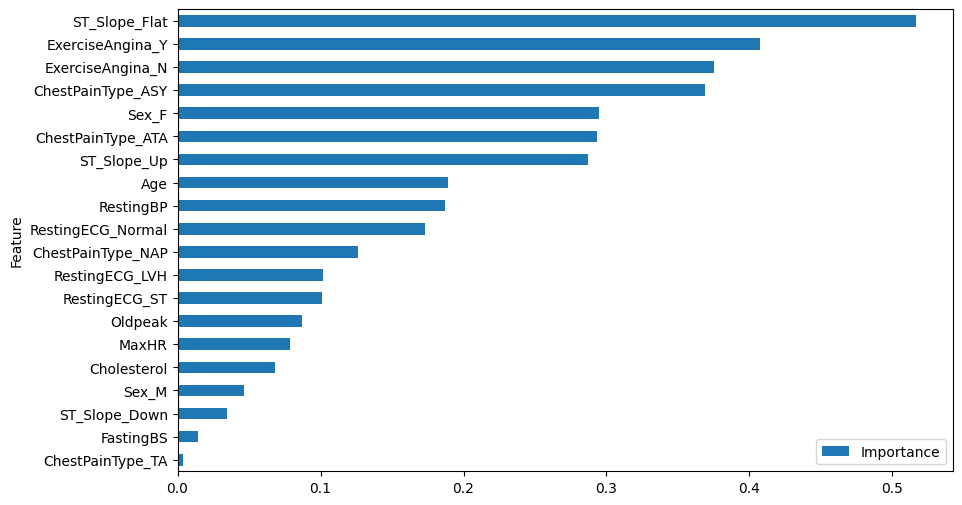

In [550]:
feature_importance = pd.DataFrame({'Feature': X_train_df.columns, 'Importance': np.abs(coefficients.flatten())})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

In [ ]:
y_pred = torch.squeeze(model(X_test)).detach().numpy()
y_pred_round = torch.squeeze(model(X_test)).round().detach().numpy()

In [ ]:
plt.scatter(y_pred_round, y_test.detach().numpy(), alpha=0.9)
plt.show()

In [ ]:
y_pred_round

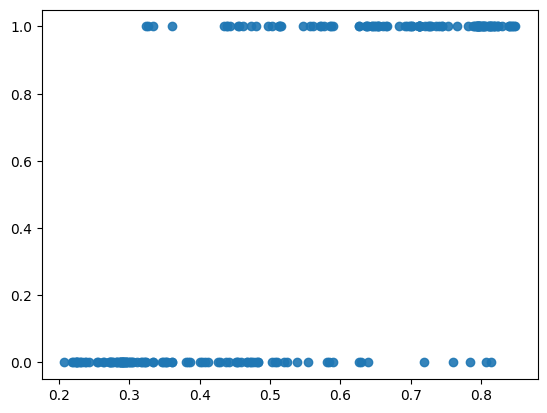

In [ ]:
plt.scatter(y_pred, y_test.detach().numpy(), alpha=0.9)
plt.show()

In [511]:
weights.detach().numpy()

array([[ 0.04932906, -0.06201904, -0.15743005, -0.16023457, -0.16749328,
        -0.00618174,  0.10327893,  0.21139748, -0.11026031,  0.1100112 ,
        -0.18168294, -0.04532874, -0.07329544, -0.01179605, -0.02139047,
        -0.22130583, -0.10126045, -0.02290231,  0.10854232, -0.14815909]],
      dtype=float32)

Think about
*  Do I want a bias?
*  Do I remove one one-hot-encoded value of each categorical feature?
*  How to get feature importance for one-hot encoded features?
*  How to deal with inbalance?
*  How to measure balanced accuracy?
*  Add Lasso

<Axes: ylabel='Feature'>

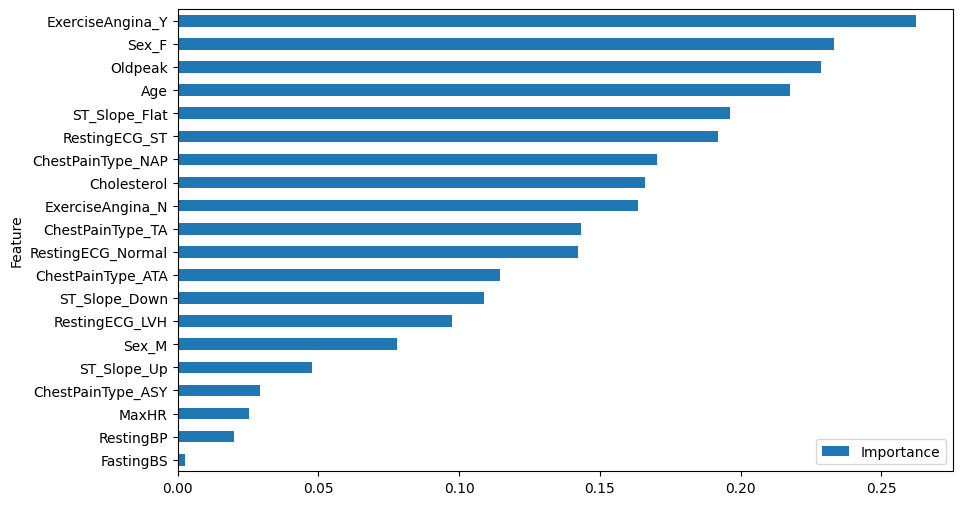

In [431]:
feature_importance = pd.DataFrame({'Feature': X_train_df.columns, 'Importance': np.abs(coefficients.flatten())})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

In [305]:
from torchmetrics.classification import BinaryF1Score

In [306]:
dim_1 = 0
dim_2 = 1

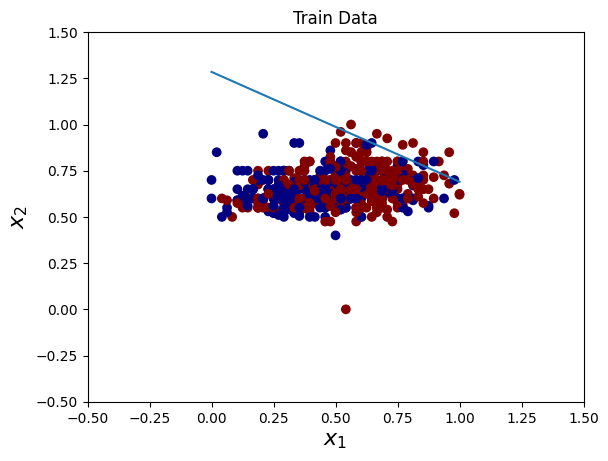

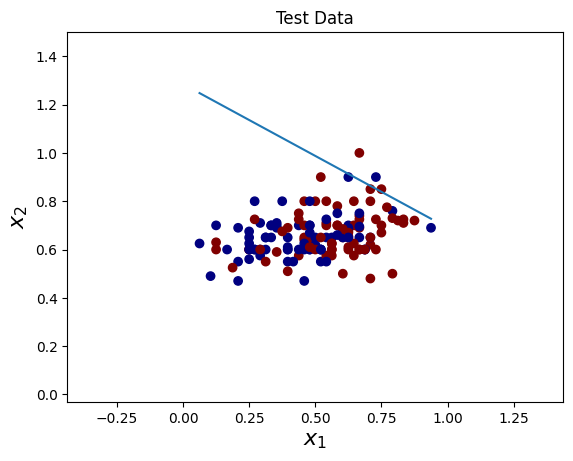

In [307]:
def model_plot(model,X,y,title,dim_1,dim_2):
    parm = {}
    b = []
    for name, param in model.named_parameters():
        parm[name]=param.detach().numpy()  
    
    w = parm['linear.weight'][0]
    b = parm['linear.bias'][0]
    plt.scatter(X[:, dim_1], X[:, dim_2], c=y,cmap='jet')
    u = np.linspace(X[:, 0].min(), X[:, 0].max(), 2)
    plt.plot(u, (0.5-b-w[0]*u)/w[1])
    plt.xlim(X[:, dim_1].min()-0.5, X[:, 0].max()+0.5)
    plt.ylim(X[:, dim_2].min()-0.5, X[:, 1].max()+0.5)
    plt.xlabel(r'$\boldsymbol{x_1}$',fontsize=16) # Normally you can just add the argument fontweight='bold' but it does not work with latex
    plt.ylabel(r'$\boldsymbol{x_2}$',fontsize=16)
    plt.title(title)
    plt.show()


# Train Data
model_plot(model,X_train,y_train,'Train Data',dim_1,dim_2)

# Test Dataset Results
model_plot(model,X_test,y_test,'Test Data',dim_1,dim_2)

In [43]:
model_2 = torch.nn.Sequential(
    torch.nn.Linear(3, 6),
    torch.nn.ReLU(),
    torch.nn.Linear(6, 6),
    torch.nn.ReLU(),
    torch.nn.Linear(6, 6),
    torch.nn.ReLU(),
    torch.nn.Linear(6, 1),
)

print(model_2(torch.randn(4, 3))) # feed it 4 random 3-dim. vectors

tensor([[0.3709],
        [0.4930],
        [0.4063],
        [0.3934]], grad_fn=<AddmmBackward0>)


### Adding One-hot Encoding

In [308]:
A = torch.tensor([3, 4, 5, 0, 1, 2])
output = F.one_hot(A, num_classes = 7)
print(output)
scalar_dim = 3
num_classes = 10

F.one_hot(torch.LongTensor([scalar_dim]), num_classes=num_classes)

tensor([[0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0],
        [1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0]])


tensor([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]])

In [309]:
num_classes = len(df_heart_train[[cols_obj_pure[0]]].value_counts()) + 1

In [310]:
F.one_hot(torch.Tensor(df_heart_train[cols_obj_pure[0]].to_numpy()), num_classes = num_classes)

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

In [ ]:
X_train, X_test = torch.Tensor(df_heart_train[features + cols_obj_pure].to_numpy()),torch.Tensor(df_heart_test[features + cols_obj_pure].to_numpy())
y_train, y_test = torch.Tensor(df_heart_train[label_col].to_numpy()),torch.Tensor(df_heart_test[label_col].to_numpy())

# Appendix

In [ ]:
# class Example(BaseClass):
#     """An example Parameterized class"""
#     timestamps = []

#     boolean                 = param.Boolean(True, doc="A sample Boolean parameter")
#     color                   = param.Color(default='#FFFFFF')
#     date                    = param.Date(dt.datetime(2017, 1, 1),
#                                          bounds=(dt.datetime(2017, 1, 1), dt.datetime(2017, 2, 1)))
#     select_string           = param.ObjectSelector(default="yellow",objects=["red","yellow","green"])
#     select_fn               = param.ObjectSelector(default=list,objects=[list,set,dict])
#     int_list                = param.ListSelector(default=[3,5], objects=[1,3,5,7,9],precedence=0.5)
#     single_file             = param.FileSelector(path='../../*/*.py*',precedence=0.5)
#     multiple_files          = param.MultiFileSelector(path='../../*/*.py?',precedence=0.5)
#     record_timestamp        = param.Action(lambda x: x.timestamps.append(dt.datetime.now()),
#                                            doc="""Record timestamp.""",precedence=0.7)

In [ ]:
class MLP(nn.Module):
  '''
    Multilayer Perceptron.
  '''
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Flatten(),
      nn.Linear(28 * 28 * 1, 64),
      nn.ReLU(),
      nn.Linear(64, 32),
      nn.ReLU(),
      nn.Linear(32, 10)
    )


  def forward(self, x):
    '''Forward pass'''
    return self.layers(x)
  
  def compute_l1_loss(self, w):
      return torch.abs(w).sum()

# https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-l1-l2-and-elastic-net-regularization-with-pytorch.md